In [68]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [69]:
# read csv file 
df = pd.read_csv("data/insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [70]:
# checking for nan values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### No missing values in any row, no need to impute/replace missing data ###

In [71]:
# one hot encode categorical columns 
# standardize numerical columns 
X = df.drop(columns = ["charges"])
y = df[["charges"]]

categorical_columns = X.select_dtypes(exclude = "number").columns
numerical_columns = X.select_dtypes(include = "number").columns

preprocessor = ColumnTransformer(
    transformers = [
        ("encoder", OneHotEncoder(), categorical_columns), 
        ("scaler", StandardScaler(), numerical_columns)
    ]
)

# X_processed = new preprocessed dataset 
X_processed = preprocessor.fit_transform(X)
X_processed

array([[ 1.        ,  0.        ,  0.        , ..., -1.43876426,
        -0.45332   , -0.90861367],
       [ 0.        ,  1.        ,  1.        , ..., -1.50996545,
         0.5096211 , -0.07876719],
       [ 0.        ,  1.        ,  1.        , ..., -0.79795355,
         0.38330685,  1.58092576],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -1.50996545,
         1.0148781 , -0.90861367],
       [ 1.        ,  0.        ,  1.        , ..., -1.29636188,
        -0.79781341, -0.90861367],
       [ 1.        ,  0.        ,  0.        , ...,  1.55168573,
        -0.26138796, -0.90861367]])

### Using PCA to visualize data ###

In [72]:
# 2 components to visualize on 3d graph 
pca = PCA(n_components = 1)
p_components = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(p_components, columns = ["PC1"])
final_pca_df = pd.concat([pca_df, df[["charges"]]], axis = 1)
final_pca_df

,PC1,charges
0,-1.529696,16884.92400
1,-0.549638,1725.55230
2,0.281843,4449.46200
3,-1.470830,21984.47061
4,-0.813172,3866.85520
...,...,...
1333,0.944094,10600.54830
1334,-1.163312,2205.98080
1335,-0.462690,1629.83350
1336,-1.668973,2007.94500


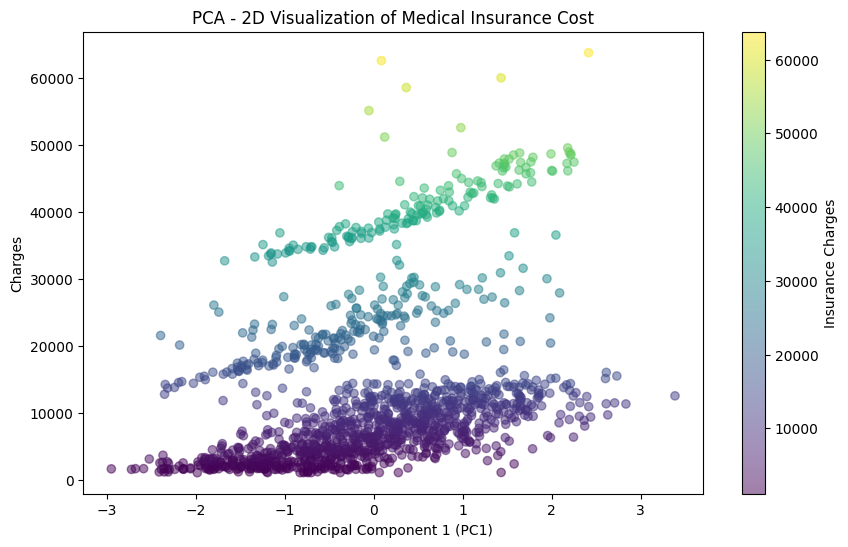

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(final_pca_df["PC1"], y = final_pca_df["charges"], c = final_pca_df["charges"], cmap = "viridis", alpha =0.5)
plt.title("PCA - 2D Visualization of Medical Insurance Cost")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Charges")
plt.colorbar(label = "Insurance Charges")
plt.show()

### Observations ###
1. Nothing too meaningful to be concluded from reducing data dimensions

### Model Training ###

In [74]:
# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.2, random_state = 42)

In [75]:
# creating pipeline 
pipe = Pipeline([
    ("linreg", LinearRegression())
])

In [76]:
params = {
    "linreg__fit_intercept": [True, False],
}

model_finder = GridSearchCV(estimator = pipe, param_grid = params, scoring = "r2", cv = 5)
model_finder.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('linreg', LinearRegression())]),
             param_grid={'linreg__fit_intercept': [True, False]}, scoring='r2')

In [77]:
# getting the best model generated from GridSearchCV
best_model = model_finder.best_estimator_

In [78]:
# weights for features 
coefficients = best_model.named_steps["linreg"].coef_
coefficients

array([[-1.46928633e+16, -1.46928633e+16,  6.29644658e+16,
         6.29644658e+16, -4.82716025e+16, -4.82716025e+16,
        -4.82716025e+16, -4.82716025e+16,  3.59125000e+03,
         2.04225000e+03,  4.91468750e+02]])

In [79]:
# r2 score 
y_preds = best_model.predict(X_test)
r2Score = r2_score(y_preds, y_test)
r2Score

0.7084722984462067

### Using Ridge and Lasso Regression # 

In [80]:
# create pipeline
pipe2 = Pipeline([
    ("lasso", Lasso())
])

In [81]:
lasso_params = {"lasso__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}

model_finder_2 = GridSearchCV(estimator = pipe2, param_grid = lasso_params, scoring = "r2", cv = 5)
model_finder_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [82]:
best_model_2 = model_finder_2.best_estimator_
best_model_2.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('lasso', Lasso(alpha=10.0))])>

In [83]:
y_preds = best_model_2.predict(X_test)
lasso_score = r2_score(y_preds, y_test)
lasso_score

0.7065813350165775

In [84]:
# create pipeline
pipe_3 = Pipeline([
    ("ridge", Ridge())
])

In [85]:
ridge_params = {"ridge__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}

model_finder_3 = GridSearchCV(estimator = pipe_3, param_grid = ridge_params, scoring = "r2", cv = 5)
model_finder_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [86]:
best_model_3 = model_finder_3.best_estimator_ 
best_model_3.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('ridge', Ridge())])>

In [87]:
y_preds = best_model_3.predict(X_test)
ridge_score = r2_score(y_preds, y_test)
ridge_score

0.7071583887320538

In [90]:
# calculating MSE and MAE for models 
y_preds = best_model.predict(X_test)
mse1 = mean_squared_error(y_preds, y_test)
y_preds = best_model_2.predict(X_test)
mse2 = mean_squared_error(y_preds, y_test)
y_preds = best_model_3.predict(X_test)
mse3 = mean_squared_error(y_preds, y_test)
print(mse1, mse2, mse3)

y_preds = best_model.predict(X_test)
mae1 = mean_absolute_error(y_preds, y_test)
y_preds = best_model_2.predict(X_test)
mae2 = mean_absolute_error(y_preds, y_test)
y_preds = best_model_3.predict(X_test)
mae3 = mean_absolute_error(y_preds, y_test)
print(mae1, mae2, mae3)

33720375.68288771 33682605.664767034 33620266.85695226
4203.566770809906 4189.298110197287 4186.901904691332


Best model for r2 score -> LinearRegression()

Best model for MAE and MSE -> Ridge()